In [1]:
pip install pandas pyarrow s3fs scikit-learn matplotlib seaborn scipy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.6/199.6 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.6/241.6 kB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 71.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.3/198.3 kB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.9/222.9 kB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.1/326.1 kB 1.4 MB/s eta 0:00:0000:01

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import s3fs
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.spatial.distance import jensenshannon
from collections import Counter

In [3]:
# 1. Charger les données depuis S3 (le fichier parquet contient une colonne 'pca_features' de type array)
s3_uri = "s3://ociae-p11/results_train/"
df = pd.read_parquet(s3_uri, storage_options={"anon": False})

In [4]:
# Vérification du nombre de composantes dans les vecteurs PCA
first_vector = df['pca_features'].iloc[0]['values']
vector_lengths = df['pca_features'].apply(lambda x: len(x['values']))

print(f"Nombre de composantes (features) dans les vecteurs PCA : {len(first_vector)}")

if vector_lengths.nunique() == 1:
    print("✅ Tous les vecteurs ont la même taille.")
else:
    print("⚠️ Attention : certaines lignes ont des tailles de vecteurs différentes !")
    print(vector_lengths.value_counts())


Nombre de composantes (features) dans les vecteurs PCA : 412
✅ Tous les vecteurs ont la même taille.


In [5]:
# 2. Extraire les 20 classes les plus fréquentes
top_labels = df['label'].value_counts().nlargest(50).index.tolist()
df = df[df['label'].isin(top_labels)].reset_index(drop=True)

In [6]:
# 3. Extraire les vecteurs de la clé 'values' des dictionnaires
X = np.stack(df['pca_features'].apply(lambda d: d['values']).values)
y = df['label'].values

In [7]:
# 4. Encodage des labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [8]:
# === 5. Train/Test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

In [9]:
# === 6. Entraînement modèle ===
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)
model.fit(X_train, y_train)

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,500
,multi_class,'multinomial'


In [10]:
# === 7. Prédiction ===
y_pred = model.predict(X_test)
y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

In [11]:
# === 8. Réduction de dimension avec t-SNE ===
reducer = TSNE(n_components=2, random_state=42, perplexity=30)
X_2d = reducer.fit_transform(X_test)

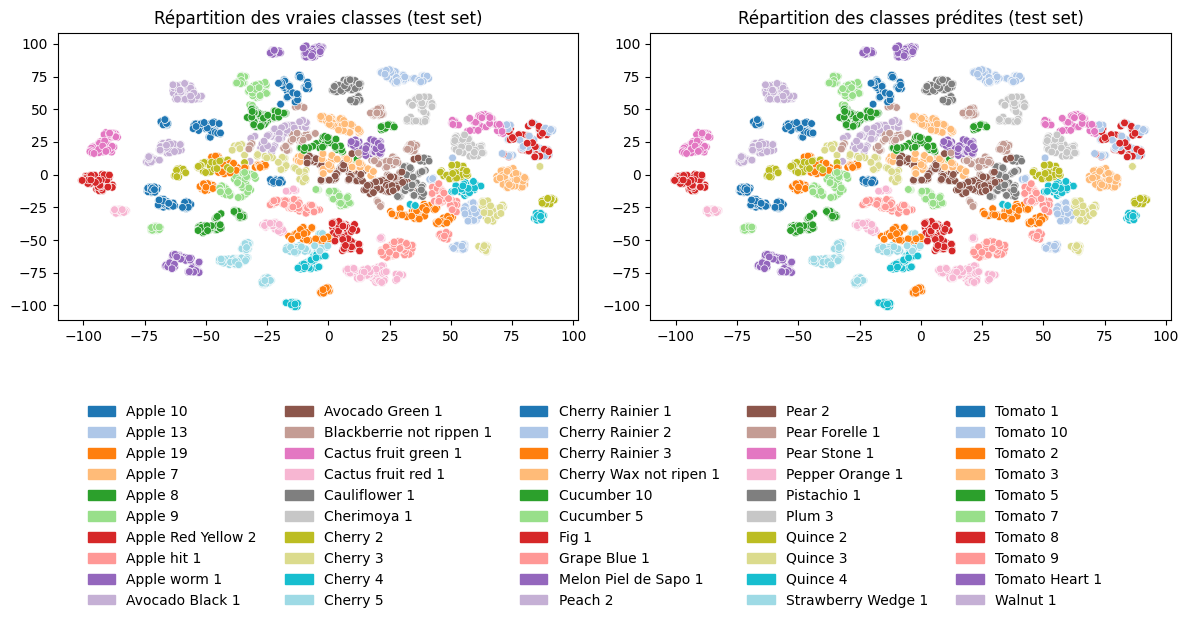

In [12]:
import matplotlib.patches as mpatches

plt.figure(figsize=(12, 5))

# Sous-graphe 1
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=y_test_labels, palette='tab20', s=30, ax=ax1, legend=False)
plt.title("Répartition des vraies classes (test set)")
xlim, ylim = plt.xlim(), plt.ylim()

# Sous-graphe 2
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=y_pred_labels, palette='tab20', s=30, ax=ax2, legend=False)
plt.title("Répartition des classes prédites (test set)")
plt.xlim(xlim)
plt.ylim(ylim)

# Légende unique en bas
classes = sorted(set(y_test_labels) | set(y_pred_labels))
palette = sns.color_palette('tab20', len(classes))
handles = [mpatches.Patch(color=palette[i], label=cls) for i, cls in enumerate(classes)]

plt.figlegend(
    handles=handles,
    loc='lower center',
    ncol=5,
    bbox_to_anchor=(0.5, -0.25),  # ⬅️ plus bas
    frameon=False
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.35)  # ⬅️ plus d’espace vertical
plt.show()


In [13]:
# === 10. Distance de Jensen-Shannon ===
real_dist = np.array([sum(y_test_labels == label) for label in top_labels])
pred_dist = np.array([sum(y_pred_labels == label) for label in top_labels])
real_dist = real_dist / real_dist.sum()
pred_dist = pred_dist / pred_dist.sum()
js_distance = jensenshannon(real_dist, pred_dist)
print(f"\nDistance de Jensen-Shannon : {js_distance:.4f}")


Distance de Jensen-Shannon : 0.0010


In [14]:
# === 11. Rapport de classification ===
print("\nRapport de classification (test set) :\n")
print(classification_report(y_test_labels, y_pred_labels, zero_division=0))


Rapport de classification (test set) :

                          precision    recall  f1-score   support

                Apple 10       1.00      1.00      1.00       140
                Apple 13       1.00      1.00      1.00       140
                Apple 19       1.00      1.00      1.00       146
                 Apple 7       1.00      1.00      1.00       139
                 Apple 8       1.00      1.00      1.00       137
                 Apple 9       1.00      1.00      1.00       139
      Apple Red Yellow 2       1.00      1.00      1.00       134
             Apple hit 1       1.00      1.00      1.00       140
            Apple worm 1       1.00      1.00      1.00       139
         Avocado Black 1       1.00      1.00      1.00       140
         Avocado Green 1       1.00      1.00      1.00       140
Blackberrie not rippen 1       1.00      1.00      1.00       135
    Cactus fruit green 1       1.00      1.00      1.00       140
      Cactus fruit red 1       1.0